TODO:

- Figure showing out of distribution generalisation somehow? Much smaller digits still go to correct protos?
- Retrain Dsprites dataset but with:
  - Hearts only one angle
  - Hearts only on LHS, Squares only TOP, ellipses taking all space?
- Try measure/compare mutual info between z and η? What to compare to? Randomly initialised models? Different components of VAEs Z?
- Figure out second lower bound for InvVAE
- Remove rot = 0 from MNIST VAE plot

In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product
from pathlib import Path

import flax
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
from absl import logging

from clu import deterministic_data

from experiments.utils import load_checkpoint
from src.models.transformation_generative_model import (
    TransformationGenerativeNet,
    create_transformation_generative_state,
)
from src.models.transformation_inference_model import (
    TransformationInferenceNet,
    create_transformation_inference_state,
)
from src.utils.proto_plots import make_get_prototype_fn
from src.utils.plotting import plot_img_array, put_in_grid
from src.utils.input import get_data
from experiments.configs.inf_best import get_config as get_inf_config
from experiments.configs.gen_best import get_config as get_gen_config

flax.config.update("flax_use_orbax_checkpointing", True)
logging.set_verbosity(logging.INFO)
plt.rcParams["savefig.facecolor"] = "white"

/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [20]:
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns

text_width = 6.75  # in  --> Confirmed with template explanation
line_width = 3.25 # in
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  #  figure titles

matplotlib.rc("font", size=fs)  # controls default text sizes
matplotlib.rc("axes", titlesize=fs)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=fs)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=fs_m1)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=fs_m1)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=7)  # legend fontsize
# matplotlib.rc(
#     "figure", titlesize=fs_p1, dpi=dpi, autolayout=True
# )  # fontsize of the figure
matplotlib.rc("lines", linewidth=1, markersize=3)
# matplotlib.rc("savefig", dpi=1200, bbox="tight")
matplotlib.rc("grid", alpha=0.3)
matplotlib.rc("axes", grid=True)

matplotlib.rc("font", **{"family": "serif", "serif": ["Times New Roman"]})
matplotlib.rc("text", usetex=True)
# add amsmath to the latex preamble
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [3]:
def get_proto_and_resample_fns(inf_config, gen_config, inf_model_checkpoint_path, gen_model_checkpoint_path):
    rng = random.PRNGKey(inf_config.seed)
    data_rng, init_rng = random.split(rng)

    train_ds, _, _ = get_data(inf_config, data_rng)
    input_shape = train_ds.element_spec["image"].shape[2:]

    inf_model = TransformationInferenceNet(
        bounds=inf_config.get("augment_bounds", None),
        offset=inf_config.get("augment_offset", None),
        **inf_config.model.to_dict(),
    )

    inf_state = create_transformation_inference_state(
        inf_model, inf_config, init_rng, input_shape
    )

    inf_final_state, _ = load_checkpoint(
        inf_model_checkpoint_path, inf_state, inf_config
    )

    gen_model = TransformationGenerativeNet(
        bounds=gen_config.get("augment_bounds", None),
        offset=gen_config.get("augment_offset", None),
        **gen_config.model.to_dict(),
    )

    gen_state = create_transformation_generative_state(
        gen_model, gen_config, init_rng, input_shape
    )

    gen_final_state, _ = load_checkpoint(
        gen_model_checkpoint_path, gen_state, gen_config
    )

    @jax.jit
    def get_prototype(x, rng):
        p_η = inf_model.apply({"params": inf_final_state.params}, x, train=False)
        η = p_η.sample(seed=rng)
        η_transform = inf_model.transform(η)
        η_transform_inv = η_transform.inverse()
        xhat = η_transform_inv.apply(x, **(inf_config.transform_kwargs or {}))
        return xhat, η

    @jax.jit
    def resample(x, rng):
        q_H_given_x = inf_model.apply({"params": inf_final_state.params}, x, train=False)
        η = q_H_given_x.sample(seed=rng)
        η_transform = inf_model.transform(η)
        η_transform_inv = η_transform.inverse()
        x_hat = η_transform_inv.apply(x, **(inf_config.transform_kwargs or {}))

        p_H_given_x_hat = gen_model.apply({"params": gen_final_state.params}, x_hat, train=False)
        η_new, η_prob = p_H_given_x_hat.sample_and_log_prob(seed=rng)
        η_new_transform = inf_model.transform(η_new)

        new_x = η_transform_inv.compose(η_new_transform).apply(
            x, **(inf_config.transform_kwargs or {})
        )

        return new_x, η_new, η_prob
    
    return get_prototype, resample

## dSprites

In [4]:
inf_config = get_inf_config("aug_dspritesv2,0")
gen_config = get_gen_config("aug_dspritesv2,0")

inf_path = Path("../best_ckpts/learning-invariances-models/inf_best_ckpt_aug_dspritesv2_0")
gen_path = Path("../best_ckpts/learning-invariances-models/gen_best_ckpt_aug_dspritesv2_0")

In [5]:
get_prototype, resample = get_proto_and_resample_fns(inf_config, gen_config, inf_path, gen_path)

I0000 00:00:1706562701.717078 2508925 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO:absl:Features before preprocessing: {'image': 'uint8[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=1, clip_values=False, key='image', key_result=None):
{'image': 'float32[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op MoveKey(key='label_shape', key_result='label'):
{'image': 'float32[64, 64, 1]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]', 'label': 'int64[]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{

In [6]:
rng = random.PRNGKey(inf_config.seed)
data_rng, init_rng = random.split(rng)

train_ds, val_ds, _ = get_data(gen_config, data_rng)

INFO:absl:Features before preprocessing: {'image': 'uint8[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=1, clip_values=False, key='image', key_result=None):
{'image': 'float32[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op MoveKey(key='label_shape', key_result='label'):
{'image': 'float32[64, 64, 1]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]', 'label': 'int64[]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[64, 64, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing:

In [7]:
batch = next(iter(val_ds))
labels = batch['label'][0]
# for each label, give the indices of the first 16 images with that label
indices = [list(np.where(labels == i)[0][:16]) for i in range(3)]
indices

[[3, 4, 6, 13, 14, 23, 30, 36, 37, 41, 43, 47, 49, 56, 80, 84],
 [1, 2, 5, 7, 8, 10, 11, 12, 15, 17, 20, 21, 29, 32, 33, 38],
 [0, 9, 16, 18, 19, 22, 24, 25, 26, 27, 28, 31, 34, 35, 42, 44]]

In [8]:
batch = next(iter(val_ds))
idxs = [
    3, 6, 13, 14, 30, 36, 37,
    1, 2, 5, 7, 8, 15, 17,
    0, 9, 16, 19, 24, 27, 28,
]
val_images = list(batch['image'][0].numpy()[idxs])

# fold_ins = range(len(val_images))

fold_ins = [
    0, 2, 3, 4, 6, 7, 8,
    0, 1, 2, 3, 4, 8, 9,
    0, 1, 2, 4, 6, 9, 10, 
]

# get the prototypes for the images
prototypes = [get_prototype(image, random.fold_in(rng, i))[0] for i, image in zip(fold_ins, val_images)]

# get the resampled images
resampled_images = [resample(image, random.fold_in(rng, i))[0] for i, image in zip(fold_ins, val_images)]

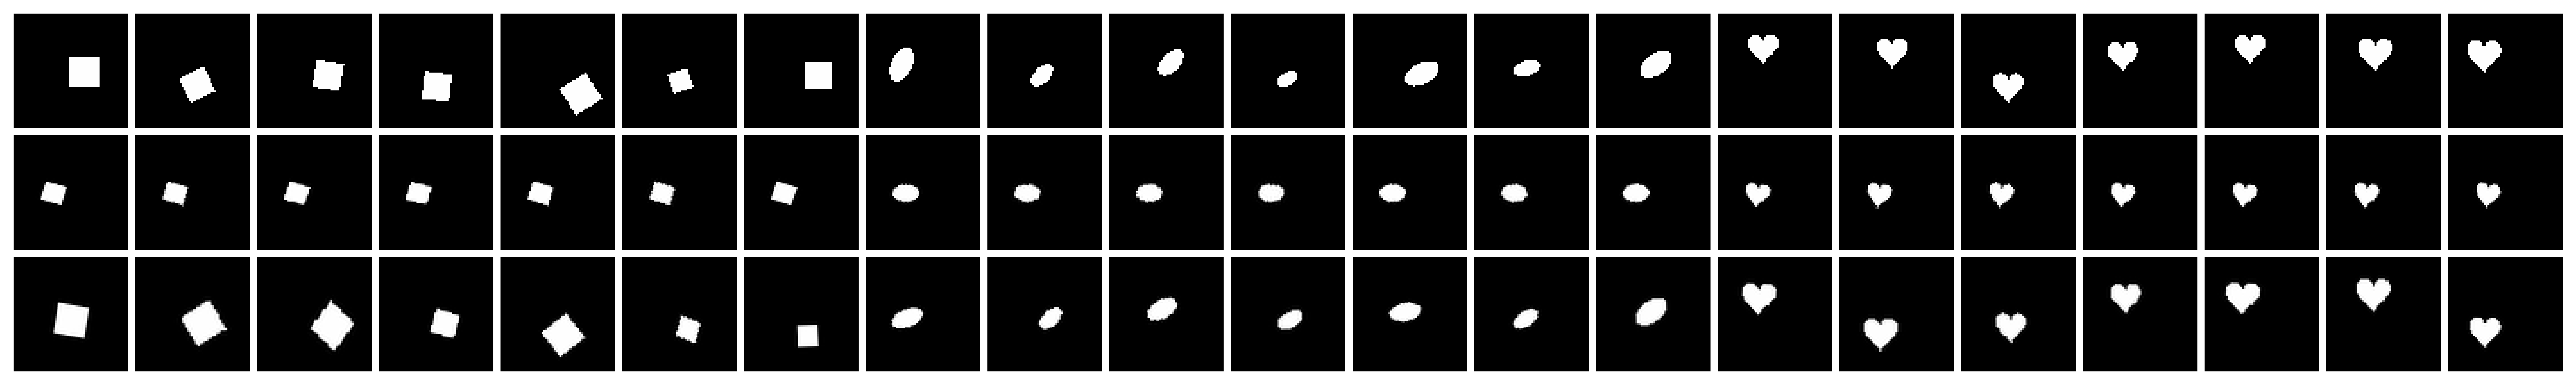

In [9]:
array = np.array(val_images + prototypes + resampled_images)

grid, xmaps, ymaps = put_in_grid(array, len(val_images), padding=4, pad_value=255, return_maps=True)

fig = plt.figure(figsize=(2 * xmaps, 2 * ymaps), dpi=dpi)
plt.imshow(grid)
plt.axis("off")
plt.tight_layout()

plt.savefig("dsprites_proto_resample.pdf", pad_inches=0.0, bbox_inches='tight', dpi=600)

plt.show()

In [10]:
squares_batch = jax.tree_map(lambda x: x[batch["label"] == 0], batch)
ellipses_batch = jax.tree_map(lambda x: x[batch["label"] == 1], batch)
hearts_batch = jax.tree_map(lambda x: x[batch["label"] == 2], batch)

resampled_hearts = [resample(image.numpy(), random.fold_in(rng, i))[0] for i, image in enumerate(hearts_batch['image'])]
resampled_ellipses = [resample(image.numpy(), random.fold_in(rng, i))[0] for i, image in enumerate(ellipses_batch['image'])]
resampled_squares = [resample(image.numpy(), random.fold_in(rng, i))[0] for i, image in enumerate(squares_batch['image'])]

In [15]:
# function to get the approximate center of mass of an image,
# by taking the average of the x and y coordinates of the pixels,
# weighted by the pixel values which range from -1 to 1
@jax.jit
@jax.vmap
def get_com(image):
    image = jnp.mean(image, axis=-1)
    mass = (image + 1) / 2
   
    # Generate coordinate grids for x and y
    y_indices, x_indices = jnp.indices(image.shape)

    # Compute total mass
    total_mass = jnp.sum(mass)

    # Compute weighted sum of positions
    x_weighted_sum = jnp.sum(x_indices * mass)
    y_weighted_sum = jnp.sum(y_indices * mass)

    # Calculate the center of mass
    center_x = x_weighted_sum / total_mass
    center_y = y_weighted_sum / total_mass

    return jnp.array((center_x, center_y))

import functools

@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None), axis_name="batch")
def resample_vmapped(image, rng):
    return resample(image, random.fold_in(rng, jax.lax.axis_index("batch")))[0]

In [16]:
square_coms = []
ellipse_coms = []
heart_coms = []
resampled_square_coms = []
resampled_ellipse_coms = []
resampled_heart_coms = []

# import tqdm
from tqdm.notebook import tqdm

for batch in tqdm(iter(val_ds)):
    batch = jax.tree_map(lambda x: x.numpy(), batch)
    squares_batch = jax.tree_map(lambda x: x[(batch["label"] == 0) & (batch["mask"] == 1)], batch)
    ellipses_batch = jax.tree_map(lambda x: x[(batch["label"] == 1) & (batch["mask"] == 1)], batch)
    hearts_batch = jax.tree_map(lambda x: x[(batch["label"] == 2) & (batch["mask"] == 1)], batch)

    square_coms.append(get_com(squares_batch['image']))
    ellipse_coms.append(get_com(ellipses_batch['image']))
    heart_coms.append(get_com(hearts_batch['image']))

    resampled_hearts = resample_vmapped(hearts_batch['image'], rng)
    resampled_ellipses = resample_vmapped(ellipses_batch['image'], rng)
    resampled_squares = resample_vmapped(squares_batch['image'], rng)

    resampled_square_coms.append(get_com(resampled_squares))
    resampled_ellipse_coms.append(get_com(resampled_ellipses))
    resampled_heart_coms.append(get_com(resampled_hearts))

square_coms = jnp.concatenate(square_coms)
ellipse_coms = jnp.concatenate(ellipse_coms)
heart_coms = jnp.concatenate(heart_coms)
resampled_square_coms = jnp.concatenate(resampled_square_coms)
resampled_ellipse_coms = jnp.concatenate(resampled_ellipse_coms)
resampled_heart_coms = jnp.concatenate(resampled_heart_coms)


0it [00:00, ?it/s]

In [22]:
resampled_square_coms.shape

(3350, 2)

In [26]:
import contextlib

@contextlib.contextmanager
def plot_kde_as_log(base=np.exp(1), support_threshold=1e-4):
    """Context manager to render density estimates on a logarithmic scale.

    Usage:

        with plot_kde_as_log():
            sns.jointplot(x='x', y='y', data=df, kind='kde')
    """
    old_call = sns._statistics.KDE.__call__

    def log_clip_fn(v):
        v = np.log(np.clip(v, support_threshold, np.inf))
        v -= np.log(support_threshold)
        v /= np.log(base)
        return v
    def new_call(*args, **kwargs):
        density, support = old_call(*args, **kwargs)
        density = log_clip_fn(density)
        return density, support

    sns._statistics.KDE.__call__ = new_call
    try:
        yield
    finally:
        sns._statistics.KDE.__call__ = old_call

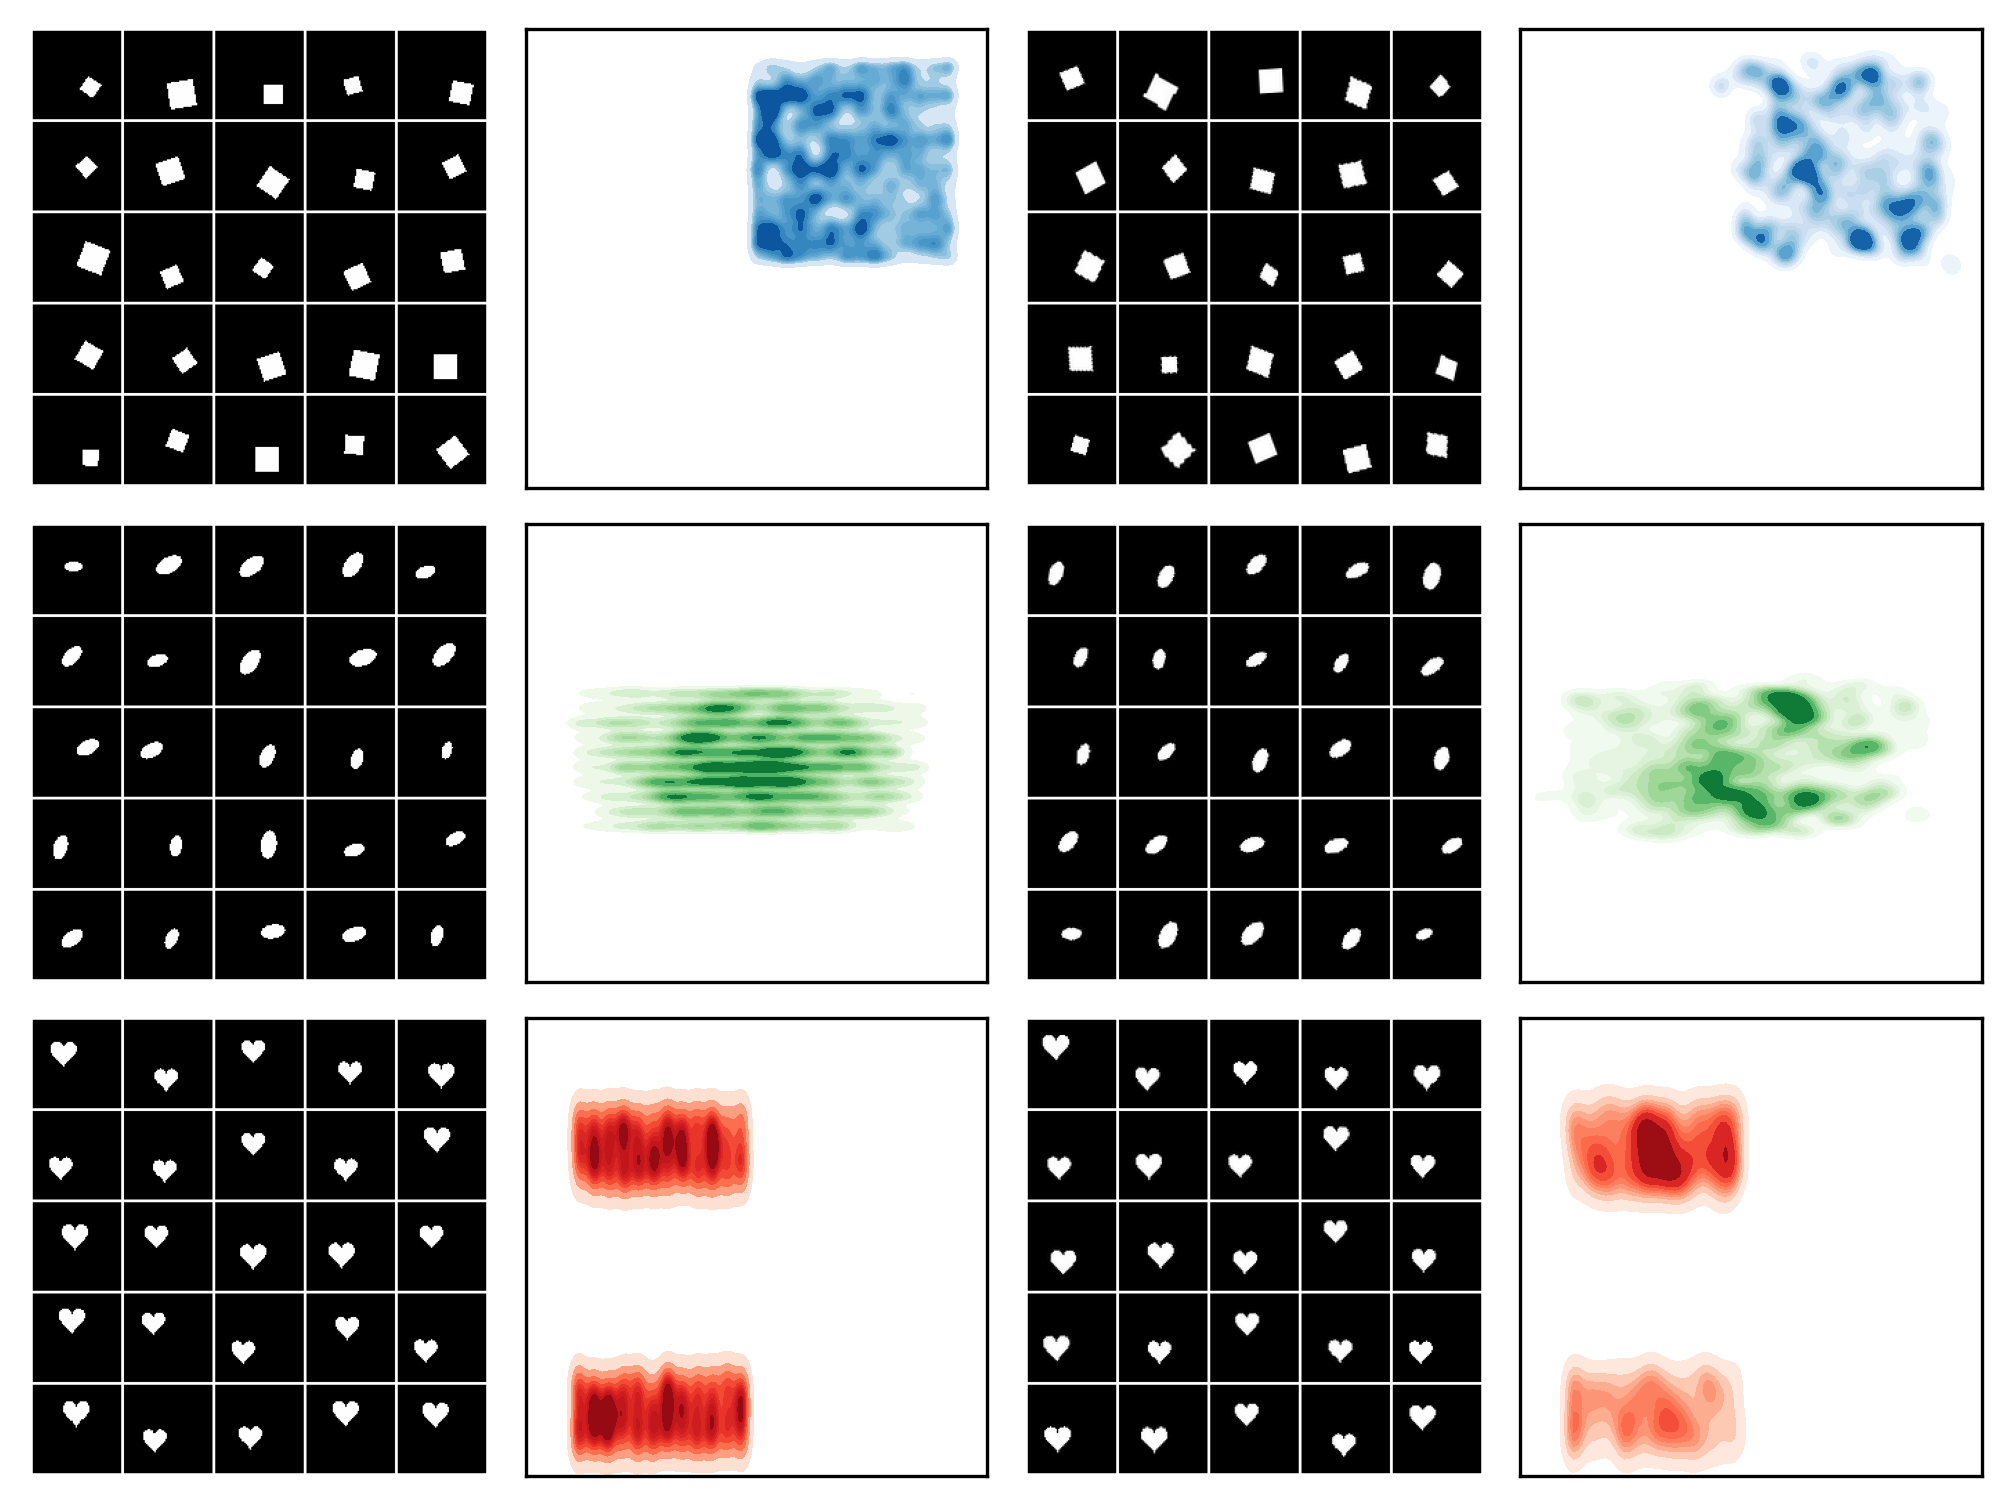

In [28]:
# make a matplotlib figure with 3 rows and 2 columns
fig, ax = plt.subplots(3, 4, figsize=(text_width, text_width / 4 * 3), dpi=300)

# # make the kdeplots share axes the same axes
for i in range(3):
    for j in [1, 3]:
        if i != 0 or j != 1:  # Skip the reference axes
            ax[i, j].sharex(ax[0, 1])
            ax[i, j].sharey(ax[0, 1])

# plot the original images in the first column
with plot_kde_as_log():
    ax[0, 0].imshow(put_in_grid(squares_batch['image'][:25], ncol=5, pad_value=255, padding=2))
    ax[1, 0].imshow(put_in_grid(ellipses_batch['image'][:25], ncol=5, pad_value=255, padding=2))
    ax[2, 0].imshow(put_in_grid(hearts_batch['image'][:25], ncol=5, pad_value=255, padding=2))


sns.kdeplot(x=square_coms[:, 0], y=square_coms[:, 1], cmap="Blues", fill=True, bw_adjust=0.5, ax=ax[0, 1])
sns.kdeplot(x=ellipse_coms[:, 0], y=ellipse_coms[:, 1], cmap="Greens", fill=True, bw_adjust=0.5, ax=ax[1, 1])
sns.kdeplot(x=heart_coms[:, 0], y=heart_coms[:, 1], cmap="Reds", fill=True, bw_adjust=0.5, ax=ax[2, 1])

# plot the resampled images in the second column
with plot_kde_as_log():
    ax[0, 2].imshow(put_in_grid(list(reversed(resampled_squares[:25])), ncol=5, pad_value=255, padding=2))
    ax[1, 2].imshow(put_in_grid(list(reversed(resampled_ellipses[:25])), ncol=5, pad_value=255, padding=2))
    ax[2, 2].imshow(put_in_grid(list(reversed(resampled_hearts[:25])), ncol=5, pad_value=255, padding=2))

sns.kdeplot(x=resampled_square_coms[:, 0], y=resampled_square_coms[:, 1], cmap="Blues", fill=True, bw_adjust=0.5, ax=ax[0, 3])
sns.kdeplot(x=resampled_ellipse_coms[:, 0], y=resampled_ellipse_coms[:, 1], cmap="Greens", fill=True, bw_adjust=0.5, ax=ax[1, 3])
sns.kdeplot(x=resampled_heart_coms[:, 0], y=resampled_heart_coms[:, 1], cmap="Reds", fill=True, bw_adjust=0.5, ax=ax[2, 3])

# remove the axes
for i in range(3):
    for j in [0, 2]:
        ax[i, j].axis('off')


# turn off the ticks
for i in range(3):
    for j in [1, 3]:
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])


# set the x and y limits
for i in range(3):
    for j in [1, 3]:
        ax[i, j].set_xlim(16, 48)
        ax[i, j].set_ylim(16, 48)


# make the figure tight
fig.tight_layout()

plt.savefig("dsprites_resample_w_dists.pdf", pad_inches=0.0, bbox_inches='tight', dpi=600)

plt.show()

## MNIST Affine

In [31]:
inf_config = get_inf_config("MNIST,1,15,50000")
gen_config = get_gen_config("MNIST,1,15,50000")

inf_path = Path("../best_ckpts/learning-invariances-models/inf_best_ckpt_MNIST_1_15_50000")
gen_path = Path("../best_ckpts/learning-invariances-models/gen_best_ckpt_MNIST_1_15_50000")

In [32]:
get_prototype, resample = get_proto_and_resample_fns(inf_config, gen_config, inf_path, gen_path)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-0.2617993877991494, θ_max=0.2617993877991494, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'la

In [33]:
rng = random.PRNGKey(inf_config.seed)
data_rng, init_rng = random.split(rng)

train_ds, val_ds, _ = get_data(gen_config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-0.2617993877991494, θ_max=0.2617993877991494, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'la

In [34]:
batch = next(iter(val_ds))
labels = batch['label'][0]
# for each label, give the indices of the first 16 images with that label
indices = [list(np.where(labels == i)[0][:16]) for i in range(10)]
indices

2024-01-29 23:30:02.385334: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[[2, 20, 32, 36, 43, 87, 121, 130, 140, 142, 158, 200, 208, 216, 223, 236],
 [1, 5, 8, 19, 45, 46, 53, 64, 65, 67, 73, 74, 80, 83, 85, 111],
 [6, 41, 48, 56, 78, 84, 101, 119, 131, 152, 153, 160, 162, 186, 192, 193],
 [14, 15, 30, 31, 44, 55, 58, 69, 77, 113, 122, 145, 150, 174, 187, 221],
 [0, 11, 25, 28, 34, 39, 49, 50, 57, 59, 60, 66, 72, 75, 79, 81],
 [52, 62, 68, 70, 76, 95, 106, 108, 139, 141, 167, 183, 201, 205, 211, 218],
 [9, 10, 21, 22, 37, 42, 51, 89, 96, 99, 126, 127, 144, 156, 159, 172],
 [3, 7, 12, 13, 16, 29, 40, 47, 61, 88, 90, 94, 109, 110, 114, 125],
 [4, 26, 38, 63, 71, 82, 97, 112, 116, 120, 138, 146, 155, 164, 166, 169],
 [17, 18, 23, 24, 27, 33, 35, 54, 86, 93, 100, 102, 105, 115, 118, 123]]

In [35]:
# Indices:
# 0 - 1, 4, 13
# 1 - 1, 8
# 2 - 4, 5
# 3 - 0, 8, 6
# 4 - 0, 2, 4
# 5 - 0, 2, 11
# 6 - 0, 1, 12
# 7 - 0, 1, 10 (2)
# 8 - 0, 8, 14
# 9 - 1, 4, 10

2024-01-24 10:36:41.241287: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


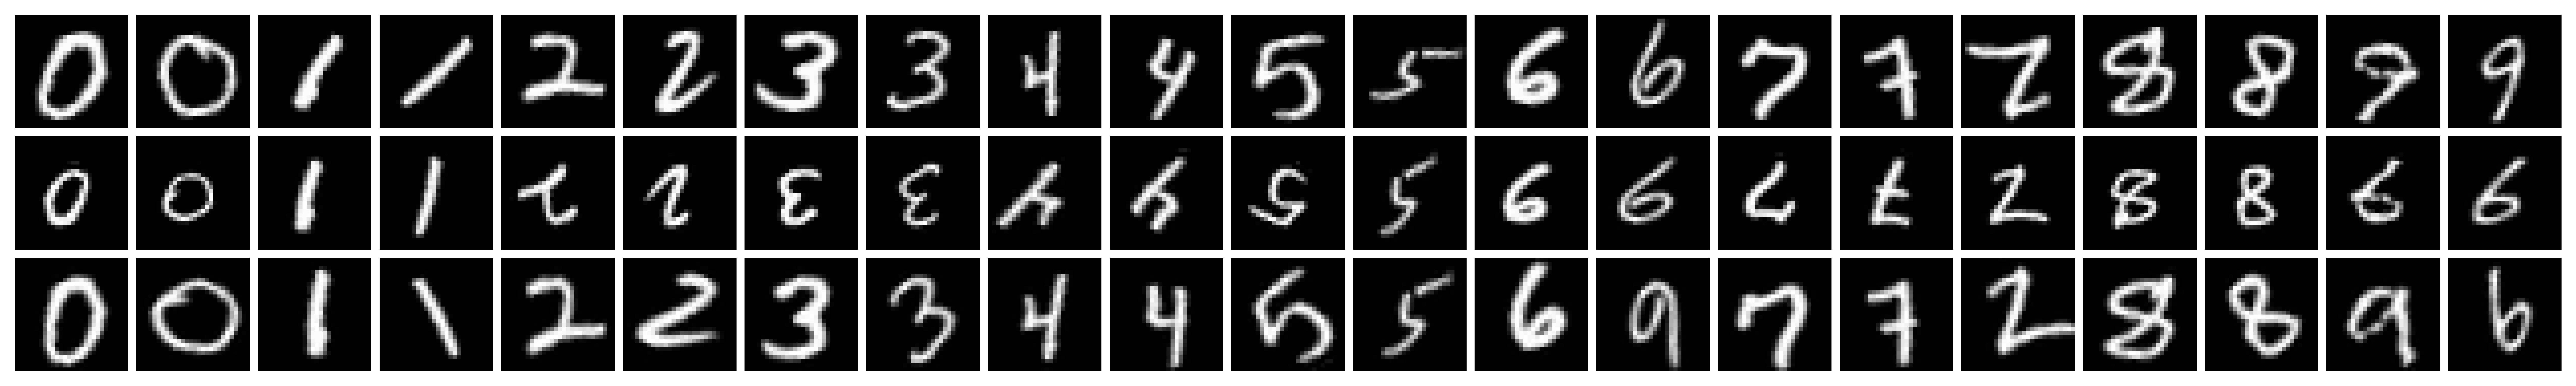

In [48]:
# get three validation images, one for each class
batch = next(iter(val_ds))
idxs = [
    20, 43, #216, 
    5, 65, #1,
    78, 84, #101,
    14, 113, #58, 
    0, 25, #34,
    52, 68, #183,
    9, 10, #144,
    3, 7, 90,
    4, 116, #166,
    18, 27, #100
]
val_images = list(batch['image'][0].numpy()[idxs])
# val_images = get_examples_of_each_label(batch['image'][0], batch['label'][0], 2)

fold_ins = [0, 1, 0, 3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3]

# get the prototypes for the images
prototypes = [get_prototype(image, random.fold_in(rng, i))[0] for i, image in zip(fold_ins, val_images)]

# get the resampled images
resampled_images = [resample(image, random.fold_in(rng, i))[0] for i, image in zip(fold_ins, val_images)]

array = np.array(val_images + prototypes + resampled_images)
# fig = plot_img_array(array, ncol=len(val_images), pad_value=255, padding=2, dpi=300)

grid, xmaps, ymaps = put_in_grid(array, len(val_images), padding=2, pad_value=255, return_maps=True)

fig = plt.figure(figsize=(2 * xmaps, 2 * ymaps), dpi=dpi)
plt.imshow(grid)
plt.axis("off")
plt.tight_layout()

plt.savefig("mnist_proto_resample.pdf", pad_inches=0.0, bbox_inches='tight', dpi=600)

plt.show()


<Figure size 640x480 with 0 Axes>

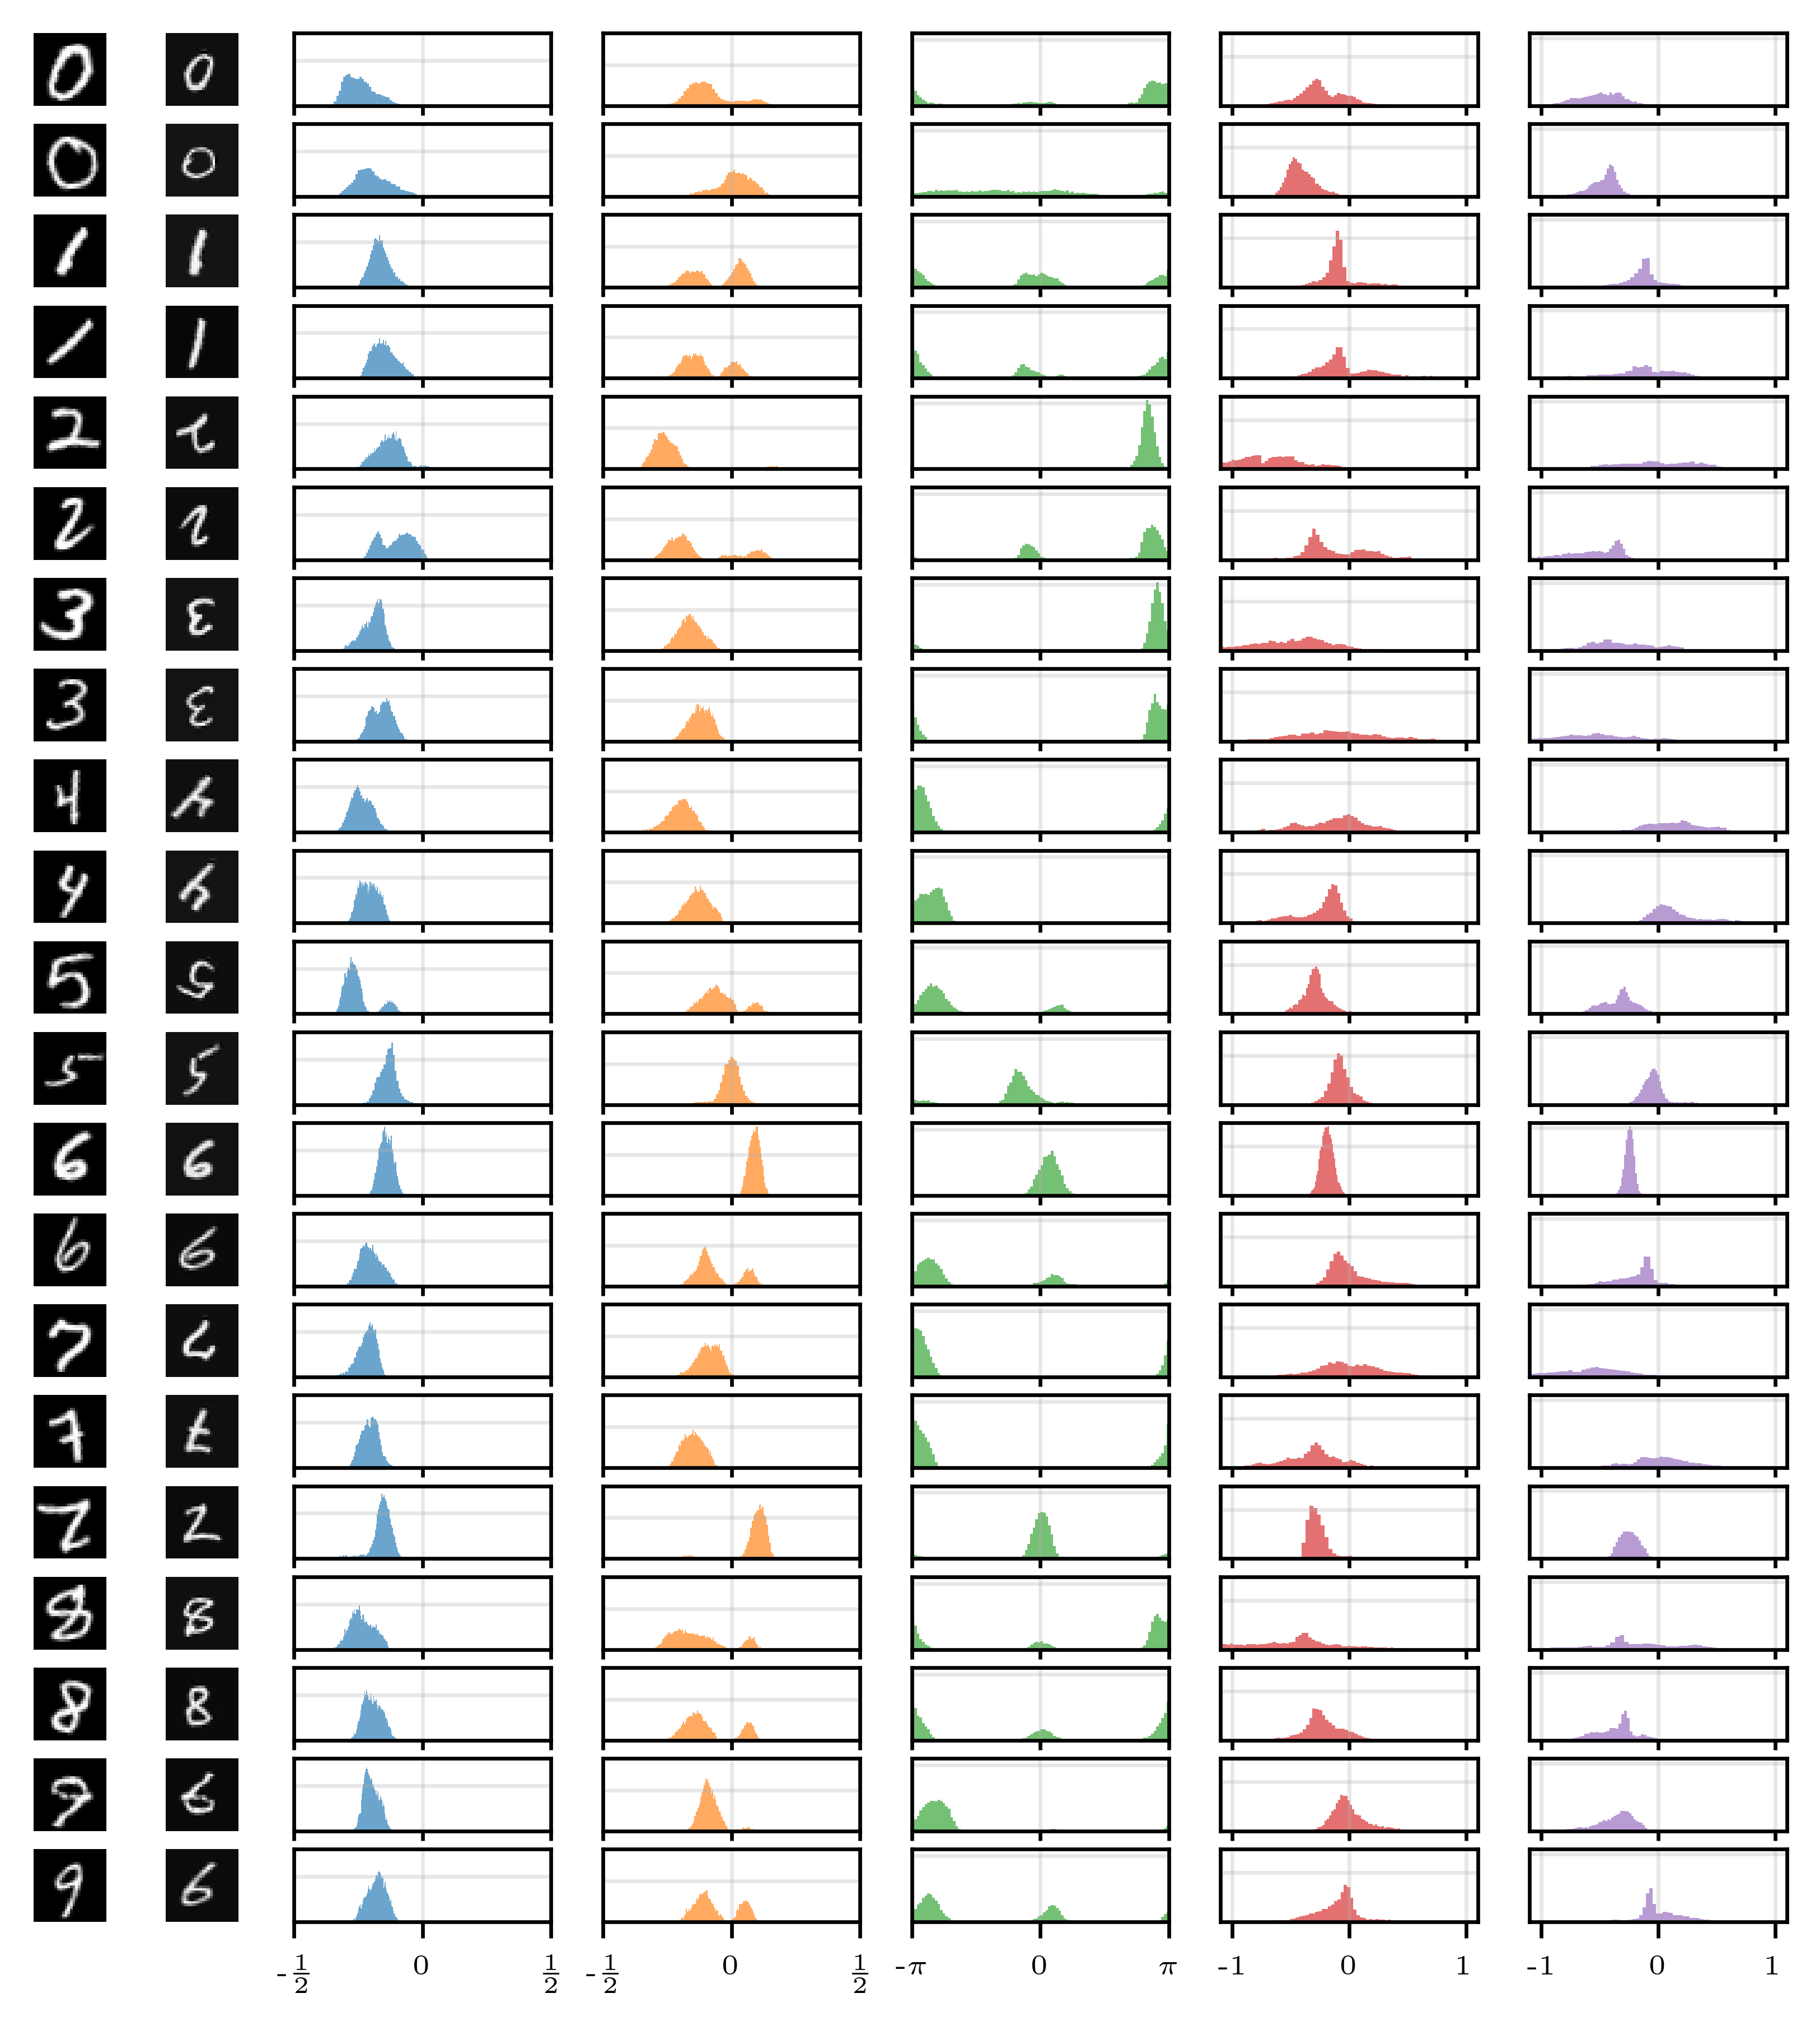

In [49]:
plt.clf()

# idxs = [
#     43,
#     65,
#     84,
#     18,
#     27,
# ]
val_images = list(batch['image'][0].numpy()[idxs])

golden_ratio = (5**.5 - 1) / 2
fig, axs = plt.subplots(nrows=len(idxs), ncols=7, dpi=600, constrained_layout=False, sharey='col',
                           figsize=(text_width, text_width * golden_ratio * len(idxs) / 12),
                           gridspec_kw={"width_ratios": [1.25, 1.25, 4, 4, 4, 4, 4]}
                           ) 

for row, (image, ax) in enumerate(zip(val_images, axs)):
    proto = get_prototype(image, rng)[0]
    _, ηs, log_probs = jax.vmap(resample, in_axes=(None, 0))(image, jax.vmap(random.fold_in, in_axes=(None, 0))(rng, np.arange(10000)))


    # # filter out the samples with low probability
    ηs_ = np.array(ηs[log_probs > np.log(1e-3)])   

    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(proto, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')

    # filter out very large and small translations / scalings
    ηs_ = ηs_[(ηs_[:, 0] > -1) & (ηs_[:, 0] < 1)]
    ηs_ = ηs_[(ηs_[:, 1] > -1) & (ηs_[:, 1] < 1)]
    ηs_ = ηs_[(ηs_[:, 3] > -2) & (ηs_[:, 3] < 2)]
    ηs_ = ηs_[(ηs_[:, 4] > -2) & (ηs_[:, 4] < 2)]

    # apply a modulus of 2pi to the rotation angle
    def wrap(x):
        return jax.lax.cond(
            (-jnp.pi <= x) & (x <= jnp.pi),
            lambda _: x,
            lambda _: ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi,
            operand=None
        )
    ηs_[:, 2] = jax.vmap(wrap)(ηs_[:, 2])

    bounds = [
        (-0.5, 0.5),
        (-0.5, 0.5),
        (-np.pi, np.pi),
        (-1.1, 1.1),
        (-1.1, 1.1),
    ]

    for i in range(5):
        ax[i + 2].hist(ηs_[:, i], bins=100, density=True, color=f'C{i}', alpha=0.66, log=False, edgecolor='none')
        ax[i + 2].set_xlim(bounds[i])
    
    ax[2].set_xticks([-.5, 0, .5])
    ax[2].set_xticklabels([r"-$\tfrac{1}{2}$", "0", r"$\tfrac{1}{2}$"])
    ax[3].set_xticks([-.5, 0, .5])
    ax[3].set_xticklabels([r"-$\tfrac{1}{2}$", "0", r"$\tfrac{1}{2}$"])
    ax[4].set_xticks([-np.pi, 0, np.pi])
    ax[4].set_xticklabels([r"-$\pi$", "0", r"$\pi$"])
    ax[5].set_xticks([-1, 0, 1])
    ax[5].set_xticklabels([r"-1", "0", r"1"])
    ax[6].set_xticks([-1, 0, 1])
    ax[6].set_xticklabels([r"-1", "0", r"1"])

    # if row == 0:
    #     # add titles to the subplots
    #     ax[0].set_title("$\mathbf{x}$")
    #     ax[1].set_title("$\hat\mathbf{x}$")
    #     ax[2].set_title(r"$T_x$")
    #     ax[3].set_title(r"$T_y$")
    #     ax[4].set_title(r"$R$")
    #     ax[5].set_title(r"$S_x$")
    #     ax[6].set_title(r"$S_y$")

    if row != len(idxs) - 1:
        # remove the ticks labels
        for i in range(7):
            ax[i].set_xticklabels([])
            ax[i].tick_params(axis='x', which='major', length=2)
    
    for i in range(7):
        ax[i].set_yticklabels([])
        # also remove the tick markers, but keep the ticks themselves
        ax[i].tick_params(axis='y', which='both', length=0)

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.margins(0.)

plt.savefig('mnist_dists.pdf', pad_inches=0.0, bbox_inches='tight', dpi=600)   
# plt.show()

<Figure size 640x480 with 0 Axes>

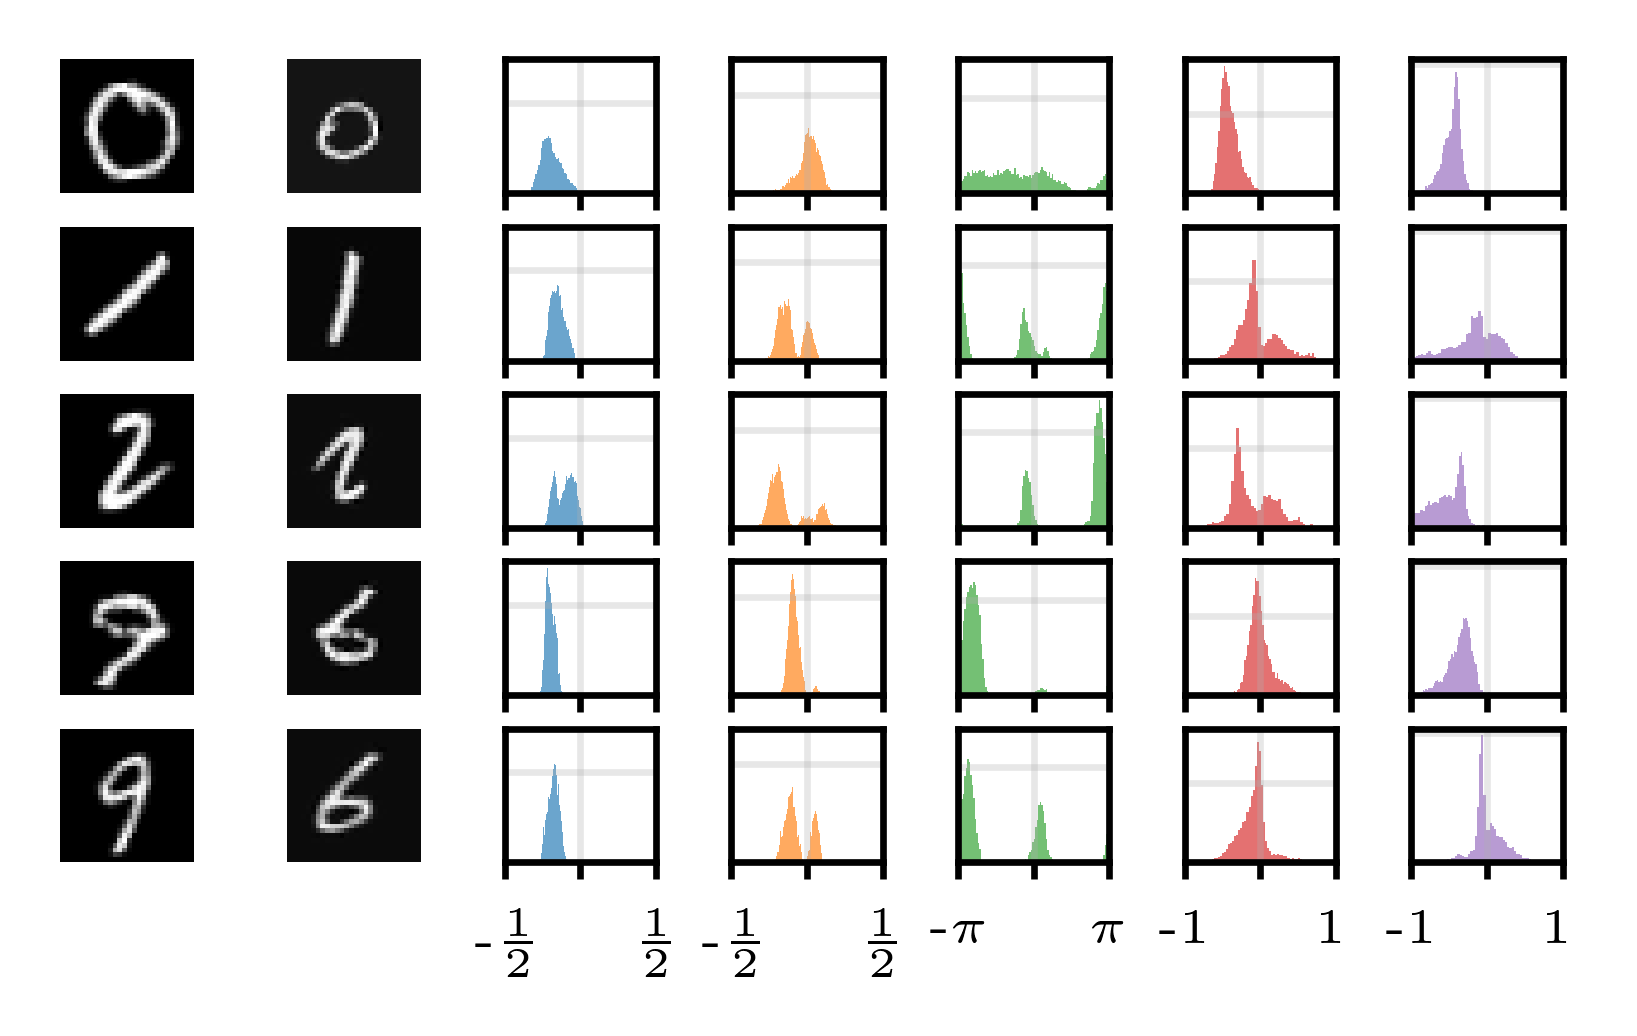

In [46]:
idxs = [
    43,
    65,
    84,
    18,
    27,
]
val_images = list(batch['image'][0].numpy()[idxs])

golden_ratio = (5**.5 - 1) / 2
fig, axs = plt.subplots(nrows=len(idxs), ncols=7, dpi=600, constrained_layout=False, sharey='col',
                           figsize=(line_width, text_width * golden_ratio * len(idxs) / 12),
                        #    gridspec_kw={"width_ratios": [1.25, 1.25, 4, 4, 4, 4, 4]}
                           ) 

for row, (image, ax) in enumerate(zip(val_images, axs)):
    proto = get_prototype(image, rng)[0]
    _, ηs, log_probs = jax.vmap(resample, in_axes=(None, 0))(image, jax.vmap(random.fold_in, in_axes=(None, 0))(rng, np.arange(10000)))


    # # filter out the samples with low probability
    ηs_ = np.array(ηs[log_probs > np.log(1e-3)])   

    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(proto, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')

    # filter out very large and small translations / scalings
    ηs_ = ηs_[(ηs_[:, 0] > -1) & (ηs_[:, 0] < 1)]
    ηs_ = ηs_[(ηs_[:, 1] > -1) & (ηs_[:, 1] < 1)]
    ηs_ = ηs_[(ηs_[:, 3] > -2) & (ηs_[:, 3] < 2)]
    ηs_ = ηs_[(ηs_[:, 4] > -2) & (ηs_[:, 4] < 2)]

    # apply a modulus of 2pi to the rotation angle
    def wrap(x):
        return jax.lax.cond(
            (-jnp.pi <= x) & (x <= jnp.pi),
            lambda _: x,
            lambda _: ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi,
            operand=None
        )
    ηs_[:, 2] = jax.vmap(wrap)(ηs_[:, 2])

    bounds = [
        (-0.5, 0.5),
        (-0.5, 0.5),
        (-np.pi, np.pi),
        (-1., 1.),
        (-1., 1.),
    ]

    for i in range(5):
        ax[i + 2].hist(ηs_[:, i], bins=100, density=True, color=f'C{i}', alpha=0.66, log=False, edgecolor='none')
        ax[i + 2].set_xlim(bounds[i])
    
    ax[2].set_xticks([-.5, 0, .5])
    ax[2].set_xticklabels([r"-$\tfrac{1}{2}$", "", r"$\tfrac{1}{2}$"])
    ax[3].set_xticks([-.5, 0, .5])
    ax[3].set_xticklabels([r"-$\tfrac{1}{2}$", "", r"$\tfrac{1}{2}$"])
    ax[4].set_xticks([-np.pi, 0, np.pi])
    ax[4].set_xticklabels([r"-$\pi$", "", r"$\pi$"])
    ax[5].set_xticks([-1, 0, 1])
    ax[5].set_xticklabels([r"-1", "", r"1"])
    ax[6].set_xticks([-1, 0, 1])
    ax[6].set_xticklabels([r"-1", "", r"1"])

    # if row == 0:
    #     # add titles to the subplots
    #     ax[0].set_title("$\mathbf{x}$")
    #     ax[1].set_title("$\hat\mathbf{x}$")
    #     ax[2].set_title(r"$T_x$")
    #     ax[3].set_title(r"$T_y$")
    #     ax[4].set_title(r"$R$")
    #     ax[5].set_title(r"$S_x$")
    #     ax[6].set_title(r"$S_y$")

    if row != len(idxs) - 1:
        # remove the ticks labels
        for i in range(7):
            ax[i].set_xticklabels([])


            
    
    for i in range(7):
        ax[i].set_yticklabels([])
        # also remove the tick markers, but keep the ticks themselves
        ax[i].tick_params(axis='y', which='both', length=0)
        ax[i].tick_params(axis='x', which='major', length=2)
    
        # set font size for the tick labels
        # ax[i].tick_params(axis='x', which='major', labelsize=5)

plt.subplots_adjust(wspace=0.5, hspace=0.25)
plt.margins(0.)

plt.savefig('mnist_dists_single.pdf', pad_inches=0.0, bbox_inches='tight', dpi=600)   
# plt.show()